# ANN or Regression and Classification

## Regression goal
- We want to predict the target value streams based on certain input columns. 

### Neural Network Considerations

- How many hidden layers?
- How many hidden units?
- What kind of layers?
- What performance is adequate?

### Preprocessing of the data

- Read data
- One-hot-encoding
- Remove outliers
- Keep columns of interest
- Normalize the data

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader, random_split
from scipy import stats
import matplotlib.pyplot as plt

In [56]:
dataset_path = "dataset/dataset-spotify-2023.csv"
data = pd.read_csv(dataset_path, encoding="latin-1")
columns = ["danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%",
"liveness_%", "speechiness_%"]
data = data.rename(columns={column: column.replace("_%", "") for column in columns})
key_None_count = data["key"].isna().sum()
in_shazam_charts_None_count = data["in_shazam_charts"].isna().sum()

print("`key` None count: ", key_None_count)
print("`in_shazam_charts` None count: ", in_shazam_charts_None_count)

# Replace NaN values with Unspecified, it may be useful later on
data = data.replace(np.nan, "Unavailable")

# Data is malformed, need to remove comma `,`
data["in_deezer_playlists"] = data["in_deezer_playlists"].replace(",", "", regex=True)
data["in_shazam_charts"] = data["in_deezer_playlists"].replace(",", "", regex=True)

# Convert columns to int64
# streams, in_deezer_playlists, in_shazam_charts
data["in_deezer_playlists"] = data["in_deezer_playlists"].astype(int)
data["in_shazam_charts"] = data["in_shazam_charts"].astype(int)

# Streams overflowed with int, so use np.int64 to fit the whole numbers
data["streams"] = data["streams"].astype(np.int64)

# Wee see that `streams` is very large compared to to other data, next larger is `in_spotify_playlists`
# Add extra column with log value of streams
# data["streams_log"] = np.log2(data["streams"])

`key` None count:  95
`in_shazam_charts` None count:  50


In [57]:
# One-hot encoding values
data = pd.get_dummies(data, columns=["key", "mode"], prefix=["key", "mode"])
data = data.applymap(lambda x: int(x) if isinstance(x, bool) else x)

In [58]:
# Select numeric columns
data_numeric = data.select_dtypes(exclude="object")
data_numeric.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   artist_count          952 non-null    int64
 1   released_year         952 non-null    int64
 2   released_month        952 non-null    int64
 3   released_day          952 non-null    int64
 4   in_spotify_playlists  952 non-null    int64
 5   in_spotify_charts     952 non-null    int64
 6   streams               952 non-null    int64
 7   in_apple_playlists    952 non-null    int64
 8   in_apple_charts       952 non-null    int64
 9   in_deezer_playlists   952 non-null    int64
 10  in_deezer_charts      952 non-null    int64
 11  in_shazam_charts      952 non-null    int64
 12  bpm                   952 non-null    int64
 13  danceability          952 non-null    int64
 14  valence               952 non-null    int64
 15  energy                952 non-null    int64
 16  acoustic

In [53]:
# # This is not working in our favor
# z_scores = np.abs(stats.zscore(data_numeric))
# data_numeric = data_numeric[(z_scores < 3).all(axis=1)]

In [59]:
# Normalize data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_numeric)
data_numeric = pd.DataFrame(data_normalized, columns=data_numeric.columns)

In [49]:
# Selected columns:
# Columns that express musicality and composition
composition_features = ["bpm", 
                        "mode_Major",
                        "mode_Minor",
                        "key_A",
                        "key_A#",
                        "key_B",
                        "key_C#",
                        "key_D",
                        "key_D#",
                        "key_E",
                        "key_F",
                        "key_F#",
                        "key_G",
                        "key_G#", 
                        "danceability",
                        "valence",
                        "energy",
                        "acousticness", 
                        "instrumentalness",
                        "liveness",
                        "speechiness"]

In [86]:
# Less columns, because I want to cry
minimal_features = ["danceability",
                    "valence",
                    "energy",
                    "instrumentalness",
                    "liveness",
                    "speechiness"]

In [87]:
# Regression
# Target value is `streams`
X = torch.tensor(data_numeric[minimal_features].values, dtype=torch.float32)
Y = torch.tensor(data_numeric["acousticness"].values, dtype=torch.float32).view(-1, 1)

# Define batch size
batch_size = 32

# Create a TensorDataset with X and Y
dataset = TensorDataset(X, Y)

# Split dataset into training and validation sets
# Let's assume we'll use 80% of the data for training and 20% for validation
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

# Use random_split to create the training and validation subsets
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# Create DataLoaders for both training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

input_size = X.shape[1] 
output_size = Y.shape[1] 


In [69]:
# This is a simple ANN
# In total, the network is composed of two layers: one hidden layer (self.fc1 + ReLU) and one output layer (self.fc2).

class SimpleANN(nn.Module):
    def __init__(self, input_size, output_size, hidden_unit_size=32):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_unit_size)
        self.fc2 = nn.Linear(hidden_unit_size, output_size)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [70]:
# This is a more complex ANN with more layers
class ComplexANN(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=[32, 64]):
        super(ComplexANN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        nn.init.xavier_uniform_(self.fc1.weight)

        self.hidden_layers = nn.ModuleList()
        for k in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
            nn.init.xavier_uniform_(self.hidden_layers[k].weight)

        self.fc_out = nn.Linear(hidden_sizes[-1], output_size)
        nn.init.xavier_uniform_(self.fc_out.weight)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        x = self.fc_out(x)
        return x

In [45]:
# This is the finalized, parameter tuned ANN
# We add dropout layers
class FinalANN(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=[32, 64], dropout_prob=0.5):
        super(FinalANN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        nn.init.xavier_uniform_(self.fc1.weight)

        self.hidden_layers = nn.ModuleList()
        for k in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
            nn.init.xavier_uniform_(self.hidden_layers[k].weight)
            self.hidden_layers.append(nn.Dropout(p=dropout_prob))  # Add dropout layer after each hidden layer

        self.fc_out = nn.Linear(hidden_sizes[-1], output_size)
        nn.init.xavier_uniform_(self.fc_out.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Dropout):
                x = layer(x)
            else:
                x = F.relu(layer(x))
        
        x = self.fc_out(x)
        return x

In [41]:
# Number of epochs
num_epochs = 1000
# For regression, it is recommended to use MSELoss
criterion = nn.MSELoss()

In [76]:
def train(model, criterion, optimizer, num_epochs, train_loader, valid_loader, patience=25):
    model.train()
    train_losses = []
    valid_losses = []
    best_valid_loss = np.inf  # Initialize with a high value
    patience_counter = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()  
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * inputs.size(0)
        
        total_valid_loss = 0
        model.eval() 

        with torch.no_grad():
            for inputs, targets in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                total_valid_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = total_train_loss / len(train_loader.dataset)
        epoch_valid_loss = total_valid_loss / len(valid_loader.dataset)
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_valid_loss:.4f}")

        # Check for early stopping
        if epoch_valid_loss < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered. No improvement for {patience} epochs.")
            break
    
    plt.figure()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.show()


Epoch [1/1000], Training Loss: 0.9747, Validation Loss: 0.8486
Epoch [2/1000], Training Loss: 0.9249, Validation Loss: 0.8110
Epoch [3/1000], Training Loss: 0.8820, Validation Loss: 0.7806
Epoch [4/1000], Training Loss: 0.8477, Validation Loss: 0.7496
Epoch [5/1000], Training Loss: 0.8165, Validation Loss: 0.7232
Epoch [6/1000], Training Loss: 0.7909, Validation Loss: 0.6998
Epoch [7/1000], Training Loss: 0.7674, Validation Loss: 0.6803
Epoch [8/1000], Training Loss: 0.7472, Validation Loss: 0.6623
Epoch [9/1000], Training Loss: 0.7287, Validation Loss: 0.6461
Epoch [10/1000], Training Loss: 0.7122, Validation Loss: 0.6321
Epoch [11/1000], Training Loss: 0.6980, Validation Loss: 0.6181
Epoch [12/1000], Training Loss: 0.6847, Validation Loss: 0.6062
Epoch [13/1000], Training Loss: 0.6739, Validation Loss: 0.5948
Epoch [14/1000], Training Loss: 0.6625, Validation Loss: 0.5854
Epoch [15/1000], Training Loss: 0.6530, Validation Loss: 0.5768
Epoch [16/1000], Training Loss: 0.6449, Validatio

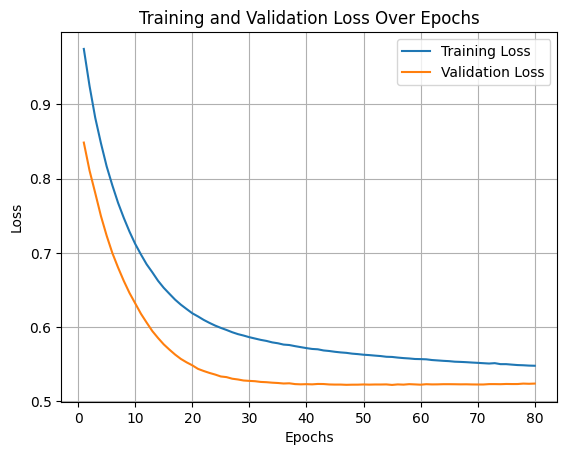

In [88]:
# Train model SimpleANN
simpleANN = SimpleANN(input_size, output_size)
# Add weight decay
optimizer = torch.optim.Adam(simpleANN.parameters(), lr=3e-4, weight_decay=1e-6)

train(simpleANN, criterion, optimizer, num_epochs, train_loader, valid_loader)

Epoch [1/1000], Training Loss: 1.0307, Validation Loss: 0.8615
Epoch [2/1000], Training Loss: 0.8428, Validation Loss: 0.7391
Epoch [3/1000], Training Loss: 0.7470, Validation Loss: 0.6636
Epoch [4/1000], Training Loss: 0.6847, Validation Loss: 0.6188
Epoch [5/1000], Training Loss: 0.6474, Validation Loss: 0.5892
Epoch [6/1000], Training Loss: 0.6208, Validation Loss: 0.5707
Epoch [7/1000], Training Loss: 0.6039, Validation Loss: 0.5586
Epoch [8/1000], Training Loss: 0.5921, Validation Loss: 0.5498
Epoch [9/1000], Training Loss: 0.5813, Validation Loss: 0.5430
Epoch [10/1000], Training Loss: 0.5738, Validation Loss: 0.5382
Epoch [11/1000], Training Loss: 0.5695, Validation Loss: 0.5327
Epoch [12/1000], Training Loss: 0.5623, Validation Loss: 0.5308
Epoch [13/1000], Training Loss: 0.5566, Validation Loss: 0.5297
Epoch [14/1000], Training Loss: 0.5516, Validation Loss: 0.5292
Epoch [15/1000], Training Loss: 0.5488, Validation Loss: 0.5284
Epoch [16/1000], Training Loss: 0.5438, Validatio

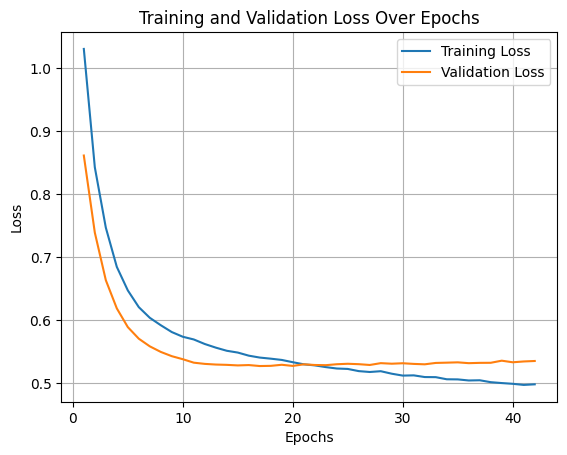

In [89]:
# Train model ComplexANN
complexANN = ComplexANN(input_size, output_size, hidden_sizes=[64, 64])
# Add weight decay
optimizer = torch.optim.Adam(complexANN.parameters(), lr=3e-4, weight_decay=1e-6)
train(complexANN, criterion, optimizer, num_epochs, train_loader, valid_loader)

Epoch [1/1000], Training Loss: 1.0956, Validation Loss: 0.8461
Epoch [2/1000], Training Loss: 0.9447, Validation Loss: 0.7572
Epoch [3/1000], Training Loss: 0.8452, Validation Loss: 0.7058
Epoch [4/1000], Training Loss: 0.7856, Validation Loss: 0.6661
Epoch [5/1000], Training Loss: 0.7737, Validation Loss: 0.6397
Epoch [6/1000], Training Loss: 0.7200, Validation Loss: 0.6233
Epoch [7/1000], Training Loss: 0.7034, Validation Loss: 0.6110
Epoch [8/1000], Training Loss: 0.6899, Validation Loss: 0.5991
Epoch [9/1000], Training Loss: 0.6547, Validation Loss: 0.5896
Epoch [10/1000], Training Loss: 0.6537, Validation Loss: 0.5802
Epoch [11/1000], Training Loss: 0.6959, Validation Loss: 0.5775
Epoch [12/1000], Training Loss: 0.6274, Validation Loss: 0.5694
Epoch [13/1000], Training Loss: 0.6447, Validation Loss: 0.5656
Epoch [14/1000], Training Loss: 0.6073, Validation Loss: 0.5626
Epoch [15/1000], Training Loss: 0.6366, Validation Loss: 0.5580
Epoch [16/1000], Training Loss: 0.6160, Validatio

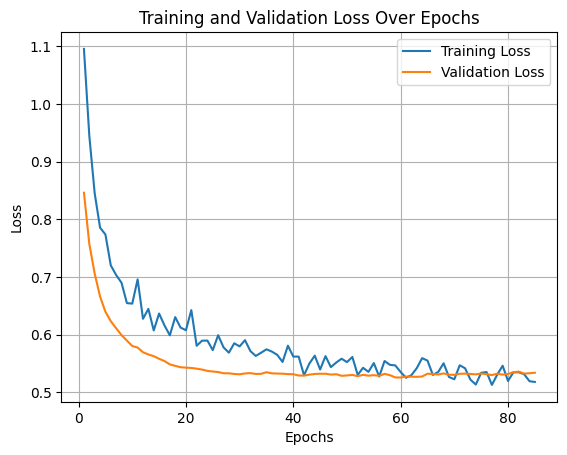

In [90]:
# Train model FinalANN
finalANN = FinalANN(input_size, output_size, hidden_sizes=[64, 64])
# Add weight decay
optimizer = torch.optim.Adam(finalANN.parameters(), lr=3e-4, weight_decay=1e-6)
train(finalANN, criterion, optimizer, num_epochs, train_loader, valid_loader)

In [ ]:
# Grid search ?
# Can't perform synthetic data augmentation in this case :(

### Performance Testing

Metrics for Regression:
- R2

Metrics for Classification :
- Precision and Recall
- F1 Score
- ROC Curve and AUC

Outcomes:
- If the model is underperforming, consider increasing the number of **layers** or **units**.
- If the model is overfitting, try reducing the complexity, adding **dropout** layers, or increasing **regularization**.


So in general, I will create a **SimpleANN**, a **ComplexANN** and a **FinalANN** and compare them performance wise.
The number of **epochs** and **learning rate** will be the same when comparing their performance.